In [1]:
import MyNN
import gym
import numpy as np
from collections import deque
import _pickle as pickle

import matplotlib.pyplot as plt

In [2]:
class ACAgent:
    def __init__(self, state_size, action_size, variances, gamma=0.995, lam=0.98,
                 actor_lr=0.001, critic_lr=0.001, method='PPO_CEM', logvar_speed=50):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma  # discount rate
        self.lam = lam # GAE disc rate
        self.method = method
        self.actor = self._build_model()
        self.critic = self._build_vf()
        self.actor.lr = actor_lr
        self.critic.lr = critic_lr
        self.scaler = MyNN.Scaler(state_size)
        self.variances = variances
        self.replay_buff_x = None
        self.replay_buff_y = None
        self.n_updates = 0
        self.grads_velo = np.zeros(variances.shape)
        self.grads_vars = np.zeros(variances.shape)
        self.var_save = None
        self.logwar_speed = logvar_speed
        self.logger = {'scores' :[] , 'adv': [], 'grads' :[], 'results' : [], 'result': 0, 'vars' : [],
                       'mean_scores': deque(maxlen=10), 'solved' : False, 'five_games' : deque(maxlen=5),
                      'best_five':-1000, 'best_score':-1000, 'threshold_crossed': None, 'episodes_played':0}


    def _build_model(self):
        model = MyNN.MyNN(self.state_size+1)
        model.add((self.state_size+1)*10, 'Tanh')
        model.add(int(np.sqrt(self.action_size*(self.state_size+1))*10), 'Tanh')
        model.add(self.action_size*10, 'Tanh')
        model.add(self.action_size, 'Linear')
        model.compile(self.method, 'Adam')
        return model
    
    def _build_vf(self):
        model = MyNN.MyNN(self.state_size+1)
        model.add((self.state_size+1)*10, 'Tanh')
        model.add(int(np.sqrt(self.state_size*50)), 'Tanh')
        model.add(5, 'Tanh')
        model.add(1, 'Linear')
        model.compile('MSE', 'Adam')
        return model
    
    def value_function_fit(self, x, y):
        if self.replay_buff_x is None:
            x_train, y_train = x, y
        else:
            x_train = np.hstack([x, self.replay_buff_x])
            y_train = np.hstack([y, self.replay_buff_y])
        self.replay_buff_x = x
        self.replay_buff_y = y
        self.critic.optimize(x_train, y_train, num_epochs=10, 
                             report_cost=False, batch_size=256)

    def get_means(self, state):
        result = self.actor.forward(state, caching='no')
        return result
    
    def update_variances(self, actions, means, adv,old_means, old_var, prob_exp, beta, DKL, DKL_targ, eta):
        self.n_updates += 1
        var = self.variances
        n = means.shape[1]
        grads = np.square(actions-means)/var
        grads = (grads-1)/(2)
        grads = grads*adv*prob_exp
        DKL_term = (-1/2)*(1 - np.divide(np.square(means-old_means), var) - np.divide(old_var, var))*beta
        if DKL > DKL_targ*2:
            DKL_add_term = (-1/2)*(1 - np.divide(np.square(means-old_means), var) - np.divide(old_var, var))*eta*(2*DKL - 4*DKL_targ)
            DKL_term = DKL_term + DKL_add_term
        grads = (1/n)*(grads + DKL_term)
        grads = np.sum(grads, axis=1, keepdims=True)
        self.grads_velo = self.grads_velo*0.9 + 0.1*grads
        corrected_v = self.grads_velo/(1-0.9**self.n_updates)
        self.grads_vars = self.grads_vars*0.99 + 0.01*np.square(grads)
        corrected_b = self.grads_vars/(1-0.99**self.n_updates)
        self.variances = np.maximum((np.exp(np.log(var) + self.actor.lr*self.logwar_speed*corrected_v/(np.sqrt(corrected_b)+1e-8))), 0.001)
    
    def save(self, path):
        save_dict = {'act_size': self.action_size , 'state_size' : self.state_size, 'gamma' : self.gamma,
                    'lamda' : self.lam, 'actor_dict': self.actor.nn_to_dict(), 'critic_dict': self.critic.nn_to_dict(),
                    'scaler_tupl': self.scaler.save('aa', to_tupl=True), 'vars' : self.variances,
                    'buff_x': self.replay_buff_x, 'buff_y': self.replay_buff_y, 'n_updates' : self.n_updates,
                    'grads_velo' : self.grads_velo, 'grads_vars': self.grads_vars, 'logvar_speed':self.logwar_speed,
                    'logger' : self.logger}
        pickle.dump(save_dict, open(path, 'wb'))
    
    def load(self, path):
        save_dict = pickle.load(open(path, 'rb'))
        self.state_size = save_dict['state_size']
        self.action_size = save_dict['act_size']
        self.gamma = save_dict['gamma']
        self.lam = save_dict['lamda']
        self.actor.load('aa', save_dict['actor_dict'])
        self.critic.load('aa', save_dict['critic_dict'])
        self.scaler.load('aa', save_dict['scaler_tupl'])
        self.variances = save_dict['vars']
        self.replay_buff_x = save_dict['buff_x']
        self.replay_buff_y = save_dict['buff_y']
        self.n_updates = save_dict['n_updates']
        self.grads_velo = save_dict['grads_velo']
        self.grads_vars = save_dict['grads_vars']
        self.logwar_speed = save_dict['logvar_speed']
        self.logger = save_dict['logger']
    
    def quick_save(self):
        agent.actor.quick_save()
        self.var_save = (self.grads_velo, self.grads_vars, self.n_updates, self.variances)
    
    def quick_load(self):
        agent.actor.quick_load()
        (self.grads_velo, self.grads_vars, self.n_updates, self.variances) = self.var_save

In [3]:
def running_reward(rewards, gamma):
    result = []
    run_rew = 0
    for reward in  rewards[0,:][::-1]:
        run_rew = run_rew*gamma + reward
        result.append(run_rew)
    return np.array(result[::-1]).reshape(1,-1)

def add_gae(traj, gamma, lam):
    rewards = traj['rewards']*(1-gamma)
    values = traj['values']
    traj['tds'] = rewards - values + np.append(traj['values'][0, 1:] * agent.gamma, 0).reshape(1,-1)
    gae = running_reward(traj['tds'], gamma*lam)
    return gae

def compute_DKL(means0, means1, vars0, vars1):
    k = means0.shape[0]
    tr = np.sum(np.divide(vars0, vars1))
    means = np.sum(np.divide(np.square(means1-means0), vars1))
    logs = np.log(np.prod(vars1)) - np.log(np.prod(vars0))
    result = 0.5*(tr + means - k + logs)
    return result/means0.shape[1]

In [4]:
def play_game(agent, render=False):
    state = env.reset().reshape((agent.state_size,1))
    unscaled_states = []
    states = []
    meanss = []
    actions = []
    rewards = []
    done = False
    mean, var = agent.scaler.get()
    time = 0.0
    while not done:
        if render:
            env.render()
        unscaled_states.append(state)
        scaled_state = np.vstack(((state-mean)/var, [[time]]))
        states.append(scaled_state)
        means = agent.get_means(scaled_state)
        meanss.append(means)
        action = means + agent.variances*np.random.normal(size=(agent.action_size,1))
        actions.append(action)
        state, reward, done, _ = env.step(action.T)
        state = state.reshape((agent.state_size,1))
        rewards.append(reward)
        time += 1e-3
        if done:
            break
    return {'unscaled': np.hstack(unscaled_states), 'states' : np.hstack(states),
            'means': np.hstack(meanss), 'actions': np.hstack(actions),
            'rewards': np.array(rewards).reshape(1,-1)}

In [5]:
def play_n_games(agent, n=20):
    trajectories = []
    for i in range(n):
        trajectory = play_game(agent)
        trajectories.append(trajectory)
        
        agent.logger['episodes_played'] += 1
        result = np.sum(trajectory['rewards'])
        agent.logger['five_games'].append(result)
        if np.mean(agent.logger['five_games']) > agent.logger['best_five']:
            agent.logger['best_five'] = np.mean(agent.logger['five_games'])
            
        if result > agent.logger['threshold'] and (agent.logger['threshold_crossed'] is None):
            agent.logger['threshold_crossed'] = agent.logger['episodes_played']
    return trajectories

In [6]:
def build_train_set(agent, trajectories):
    for traj in trajectories:
        traj['disc_sum_rew'] = running_reward(traj['rewards']*(1-agent.gamma), agent.gamma)
        traj['values'] = agent.critic.forward(traj['states'])
        traj['GAE'] = add_gae(traj, agent.gamma, agent.lam)
    X = np.hstack([t['states'] for t in trajectories])
    Y = np.hstack([t['means'] for t in trajectories])
    actions = np.hstack([t['actions'] for t in trajectories])
    disc_sum_rew = np.hstack([t['disc_sum_rew'] for t in trajectories])
    adv = np.hstack([t['GAE'] for t in trajectories])
    adv = (adv - adv.mean())/(adv.std() + 1e-6)
    return X, Y, actions, adv, disc_sum_rew

In [7]:
env = gym.make('HalfCheetah-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
variances = np.exp(-np.ones((action_size,1)))

base_lr = 9e-4/np.sqrt(int(np.sqrt(action_size*state_size)*10))
vf_lr = 1e-2/np.sqrt(int(np.sqrt(state_size*50)))
logvar_speed = (action_size*100)//48
n_episods = 10

agent = ACAgent(state_size, action_size, actor_lr=base_lr,
                critic_lr=vf_lr, gamma=0.995, lam=0.98, method='Cont_PPO',
               variances= variances, logvar_speed = logvar_speed)
d = {'beta': 1, 'eta':50, 'DKL_targ' : 0.003}

In [8]:
agent.logger['threshold'] = 4700
solved_score = 5000

trajectories = play_n_games(agent, n=n_episods)
score = np.mean([(np.sum(t['rewards']), np.var(t['rewards'])) for t in trajectories], axis=0)

agent.logger['episodes_played'] = 0
agent.logger['result'] = score[0]

In [9]:
%%time
for time in range(1, 3000//n_episods+1):
    trajectories = play_n_games(agent, n=n_episods)
    agent.scaler.update(np.hstack([t['unscaled'] for t in trajectories]))
    score = np.mean([(np.sum(t['rewards']), np.var(t['rewards'])) for t in trajectories], axis=0)
    agent.logger['scores'].append(score)
    X_batch, d['old_means'], d['actions'], d['adv'], disc_sum_rew = build_train_set(agent, trajectories)
    d['old_vars'] = agent.variances
    print(time, score[0])
    
    i = 1
    agent.quick_save()
    save_beta = d['beta']
    
    while i < 21:
        restart = False
        d['means'] = agent.actor.forward(X_batch)
        agent.actor.cache['A0'] = X_batch
        d['vars'] = agent.variances
        d['DKL'] = compute_DKL(d['old_means'], d['means'], d['old_vars'], d['vars'])
        
        if i > 10 and d['DKL'] > d['DKL_targ']*4:
            print('DKL diverges badly, loading earlier version, increasing beta and starting training again')
            restart = True
            adj_lr = agent.actor.lr
            d['beta'] = np.minimum(35, d['beta']*1.5)
            if d['beta'] > 30:
                adj_lr = np.maximum(agent.actor.lr/1.5, base_lr*0.1)
                if adj_lr < base_lr*0.11:
                    print('Skipping current set of gradients, restore agent and beta')
                    agent.quick_load()
                    pickle.dump(d, open('spoiled_dict_'+str(time), 'wb'))
                    d['beta'] = save_beta
                    break
                print('Decreasing learning rate, currnet lr multipler is {}'.format(adj_lr/base_lr))
            agent.quick_load()
            agent.actor.lr = adj_lr
            i = 1
        
        if not restart:
            log_p = -0.5*(np.log(d['vars']) + np.divide(np.square(d['actions'] - d['means']), d['vars']))
            log_old_p = -0.5*(np.log(d['old_vars']) + np.divide(np.square(d['actions'] - d['old_means']), d['old_vars']))
            d['prob_exp'] = np.exp(log_p - log_old_p)
            agent.logger['adv'].append([np.min(d['adv']), np.max(d['adv']), np.mean(np.abs(d['adv']))])
            grads = agent.actor.get_grads(d)
            agent.logger['grads'].append([np.min(grads), np.max(grads), np.mean(grads), np.mean(np.abs(grads))])
            agent.actor.backward(_, _, _, grads=grads)
            agent.actor.number_of_updates +=1
            agent.actor.update_parameters()
            agent.update_variances(d['actions'], d['means'], d['adv'], d['old_means'],
                                   d['old_vars'], d['prob_exp'], d['beta'], d['DKL'], d['DKL_targ'], d['eta'])
            i += 1
        
    if d['DKL'] > d['DKL_targ']*2:
        d['beta'] = np.minimum(35, d['beta']*1.5)
        print('Increasing beta')
        if d['beta'] > 30 and agent.actor.lr>base_lr*0.05:
            agent.actor.lr = np.maximum(agent.actor.lr/1.5, base_lr*0.1)
            print('Decreasing learning rate')
    elif d['DKL'] < d['DKL_targ']*0.5:
        d['beta'] = np.maximum(1/35, d['beta']/1.5)
        print('Decreasing beta')
        if d['beta'] < 1/30 and agent.actor.lr<base_lr*20:
            agent.actor.lr = np.minimum(agent.actor.lr*1.5, base_lr*10)
            print('Increasing learning rate')
    else:
        print('Beta remains the same')
    
    if score[0] > agent.logger['best_score']:
        agent.save('best')
        agent.logger['best_score'] = score[0]
    
    agent.logger['mean_scores'].append(score[0])
    if np.mean(agent.logger['mean_scores']) >= solved_score:
        agent.logger['solved'] = True
        
    agent.value_function_fit(X_batch, disc_sum_rew)
    agent.logger['result'] = agent.logger['result']*0.98+score[0]*0.02
    agent.logger['results'].append(agent.logger['result'])
    agent.logger['vars'].append(agent.variances)
    
    print('DKL:{:f}, lr_mlt: {:f}, beta: {:f}'.format(d['DKL'], agent.actor.lr/base_lr, d['beta']))
    print('********************************')

if agent.logger['solved']:
    print('Environment is solved')

1 -464.56985502761233
Increasing beta
DKL:0.007569, lr_mlt: 1.000000, beta: 1.500000
********************************
2 -265.04837905812957
Decreasing beta
DKL:0.001329, lr_mlt: 1.000000, beta: 1.000000
********************************
3 -359.25251819194335
Beta remains the same
DKL:0.003750, lr_mlt: 1.000000, beta: 1.000000
********************************
4 -252.64570495626384
Beta remains the same
DKL:0.004041, lr_mlt: 1.000000, beta: 1.000000
********************************
5 -142.33815751141833
Beta remains the same
DKL:0.004171, lr_mlt: 1.000000, beta: 1.000000
********************************
6 -81.09369983127303
Beta remains the same
DKL:0.003663, lr_mlt: 1.000000, beta: 1.000000
********************************
7 -30.755530622855275
Beta remains the same
DKL:0.003968, lr_mlt: 1.000000, beta: 1.000000
********************************
8 85.84165601072485
Beta remains the same
DKL:0.003711, lr_mlt: 1.000000, beta: 1.000000
********************************
9 194.11044703531857
Be

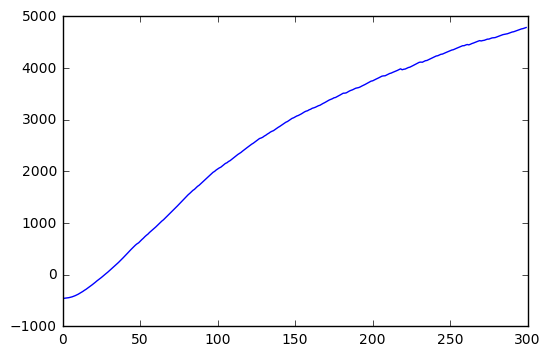

In [10]:
plt.plot(agent.logger['results'])
plt.show()

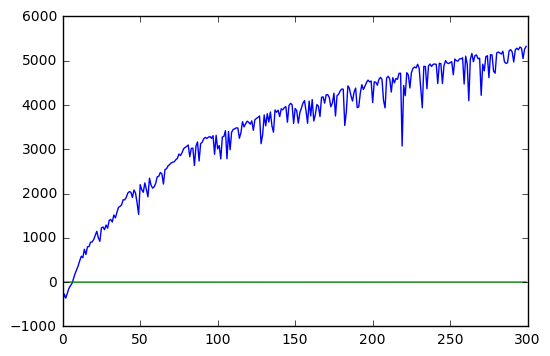

In [11]:
plt.plot(agent.logger['scores'])
plt.show()

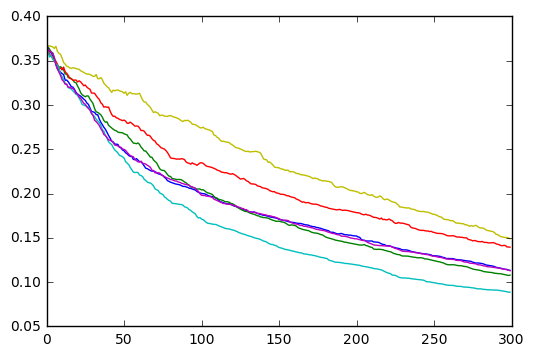

In [12]:
for i in range(agent.action_size):
    plt.plot(np.array(agent.logger['vars'])[:,i])
plt.show()

In [13]:
agent.logger['best_five']

5371.327579001728

In [14]:
traj = play_game(agent, render=True)

In [15]:
np.sum(traj['rewards'])

5416.37755414548

In [16]:
agent.logger['solved']

True

In [17]:
agent.logger['threshold_crossed']

1971

In [18]:
agent.logger['episodes_played']

3000

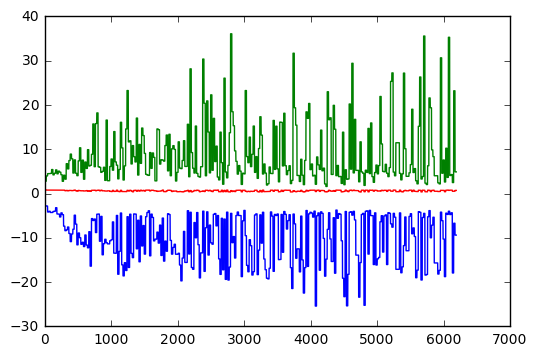

In [19]:
plt.plot(agent.logger['adv'])
plt.show()

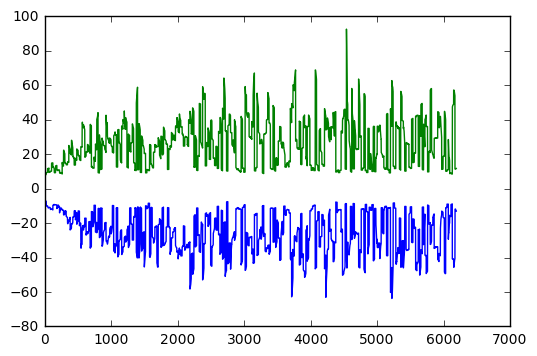

In [20]:
plt.plot(np.array(agent.logger['grads'])[:,:2])
plt.show()

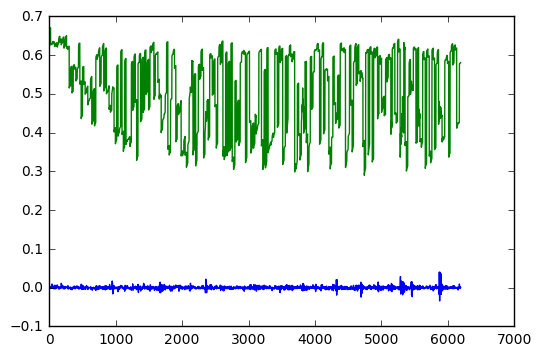

In [21]:
plt.plot(np.array(agent.logger['grads'])[:,2:])
plt.show()